In [1]:
import pandas as pd
import numpy as np
import copy
import functools
import itertools
import numpy as np
from itertools import product
from functools import partial
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.signal import fftconvolve
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble._forest import BaseForest
from sklearn.ensemble._bagging import BaseBagging
from sklearn.ensemble._forest import _generate_sample_indices, _get_n_samples_bootstrap
import warnings

warnings.filterwarnings('ignore')

In [2]:
def gfit(X, sigma, p=5, nbin=200, unif_fraction=0.1):
    """
    Fit empirical Bayes prior in the hierarchical model [Efron2014]_.

    .. math::

        mu ~ G, X ~ N(mu, sigma^2)

    Parameters
    ----------
    X: ndarray
        A 1D array of observations.
    sigma: float
        Noise estimate on X.
    p: int
        Number of parameters used to fit G. Default: 5
    nbin: int
        Number of bins used for discrete approximation.
        Default: 200
    unif_fraction: float
        Fraction of G modeled as "slab". Default: 0.1

    Returns
    -------
    An array of the posterior density estimate g.
    """
    min_x = min(min(X) - 2 * np.std(X, ddof=1), 0)
    max_x = max(max(X) + 2 * np.std(X, ddof=1),
                np.std(X, ddof=1))
    xvals = np.linspace(min_x, max_x, nbin)
    binw = (max_x - min_x) / (nbin - 1)

    zero_idx = max(np.where(xvals <= 0)[0])
    noise_kernel = norm().pdf(xvals / sigma) * binw / sigma

    if zero_idx > 0:
        noise_rotate = noise_kernel[list(np.arange(zero_idx, len(xvals))) +
                                    list(np.arange(0, zero_idx))]
    else:
        noise_rotate = noise_kernel

    XX = np.zeros((p, len(xvals)), dtype=np.float)
    for ind, exp in enumerate(range(1, p+1)):
        mask = np.ones_like(xvals)
        mask[np.where(xvals <= 0)[0]] = 0
        XX[ind, :] = pow(xvals, exp) * mask
    XX = XX.T

    def neg_loglik(eta):
        mask = np.ones_like(xvals)
        mask[np.where(xvals <= 0)[0]] = 0
        g_eta_raw = np.exp(np.dot(XX, eta)) * mask
        if ((np.sum(g_eta_raw) == np.inf) |
            (np.sum(g_eta_raw) <=
                100 * np.finfo(np.double).tiny)):
                return (1000 * (len(X) + sum(eta ** 2)))

        g_eta_main = g_eta_raw / sum(g_eta_raw)
        g_eta = ((1 - unif_fraction) * g_eta_main +
                 unif_fraction * mask / sum(mask))
        f_eta = fftconvolve(g_eta, noise_rotate, mode='same')
        return np.sum(np.interp(X, xvals,
                      -np.log(np.maximum(f_eta, 0.0000001))))

    eta_hat = minimize(neg_loglik,
                       list(itertools.repeat(-1, p))).x
    g_eta_raw = np.exp(np.dot(XX, eta_hat)) * mask
    g_eta_main = g_eta_raw / sum(g_eta_raw)
    g_eta = ((1 - unif_fraction) * g_eta_main +
             unif_fraction * mask) / sum(mask)

    return xvals, g_eta


def gbayes(x0, g_est, sigma):
    """
    Estimate Bayes posterior with Gaussian noise [Efron2014]_.

    Parameters
    ----------
    x0: ndarray
        an observation
    g_est: float
        a prior density, as returned by gfit
    sigma: int
        noise estimate

    Returns
    -------
    An array of the posterior estimate E[mu | x0]
    """

    Kx = norm().pdf((g_est[0] - x0) / sigma)
    post = Kx * g_est[1]
    post /= sum(post)
    return sum(post * g_est[0])


def calibrateEB(variances, sigma2):
    """
    Calibrate noisy variance estimates with empirical Bayes.

    Parameters
    ----------
    vars: ndarray
        List of variance estimates.
    sigma2: int
        Estimate of the Monte Carlo noise in vars.

    Returns
    -------
    An array of the calibrated variance estimates
    """
    if (sigma2 <= 0 or min(variances) == max(variances)):
        return(np.maximum(variances, 0))
    sigma = np.sqrt(sigma2)
    eb_prior = gfit(variances, sigma)
    # Set up a partial execution of the function
    part = functools.partial(gbayes, g_est=eb_prior,
                             sigma=sigma)
    if len(variances) >= 200:
        # Interpolate to speed up computations:
        calib_x = np.percentile(variances,
                                np.arange(0, 102, 2))
        calib_y = list(map(part, calib_x))
        calib_all = np.interp(variances, calib_x, calib_y)
    else:
        calib_all = list(map(part, variances))

    return np.asarray(calib_all)

def compute_VIJ(forest, X_train, X_test, calibrate=True):
    def _infer_inbag(n_samples, forest):
        n_trees = forest.n_estimators
        inbag = np.zeros((n_samples, n_trees))
        sample_idx = []
        if isinstance(forest, BaseForest):
            n_samples_bootstrap = _get_n_samples_bootstrap(n_samples, forest.max_samples)

            for t_idx in range(n_trees):
                sample_idx.append(
                    _generate_sample_indices(
                        forest.estimators_[t_idx].random_state,
                        n_samples,
                        n_samples_bootstrap,
                    )
                )
                inbag[:, t_idx] = np.bincount(sample_idx[-1], minlength=n_samples)
        elif isinstance(forest, BaseBagging):
            for t_idx, estimator_sample in enumerate(forest.estimators_samples_):
                sample_idx.append(estimator_sample)
                inbag[:, t_idx] = np.bincount(sample_idx[-1], minlength=n_samples)

        return inbag 

    def _core_computation(inbag, pred_centered, n_trees):
        return np.sum((np.dot(inbag - 1, pred_centered.T) / n_trees) ** 2, 0) 

    def _bias_correction(V_IJ, inbag, pred_centered, n_trees):
        n_train_samples = inbag.shape[0]
        n_var = np.mean(
            np.square(inbag[0:n_trees]).mean(axis=1).T.view()
            - np.square(inbag[0:n_trees].mean(axis=1)).T.view()
        )
        boot_var = np.square(pred_centered).sum(axis=1) / n_trees
        bias_correction = n_train_samples * n_var * boot_var / n_trees
        V_IJ_unbiased = V_IJ - bias_correction
        return V_IJ_unbiased 

    inbag = _infer_inbag(X_train.shape[0], forest) 
    pred = np.array([tree.predict(X_test) for tree in forest]).T
    pred_mean = np.mean(pred, 0)
    pred_centered = pred - pred_mean
    n_trees = forest.n_estimators
    V_IJ = _core_computation(inbag, pred_centered, n_trees)
    V_IJ_unbiased = _bias_correction(V_IJ, inbag, pred_centered, n_trees)
    
    # calibration
    if calibrate:
        calibration_ratio = 2
        n_sample = np.ceil(n_trees / calibration_ratio)
        new_forest = copy.deepcopy(forest)
        random_idx = np.random.permutation(len(new_forest.estimators_))[: int(n_sample)]
        new_forest.estimators_ = list(np.array(new_forest.estimators_)[random_idx])
        if hasattr(new_forest, "_seeds"):
            new_forest._seeds = new_forest._seeds[random_idx]

        new_forest.n_estimators = int(n_sample)

        results_ss = compute_VIJ(
            new_forest,
            X_train,
            X_test,
            calibrate=False
        )
        # Use this second set of variance estimates
        # to estimate scale of Monte Carlo noise
        sigma2_ss = np.mean((results_ss - V_IJ_unbiased) ** 2)
        delta = n_sample / n_trees
        sigma2 = (delta ** 2 + (1 - delta) ** 2) / (2 * (1 - delta) ** 2) * sigma2_ss

        # Use Monte Carlo noise scale estimate for empirical Bayes calibration
        V_IJ_calibrated = calibrateEB(V_IJ_unbiased, sigma2)
        return V_IJ_calibrated
    return V_IJ_unbiased

### Figure 2

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

In [9]:
n = 500
B = 10000
eps_var = 1/2**2
X = np.linspace(0, 1, num=n, endpoint=True).reshape((-1, 1))
def simulation_figure_2(random_seed):
    np.random.seed(random_seed)
    y = np.zeros(shape=(n,1))
    y[(X>=0.35) & (X<=0.65)] = 0.7
    y[(X>=0.45) & (X<=0.55)] = 1.4
    y = (y+ np.random.normal(0, eps_var, size = (n, 1))).ravel()
    # split the datainto training and test set
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
                                                        
    bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes = 5), n_estimators=B, random_state=random_seed)
    bagging.fit(X, y)
    V_IJ = compute_VIJ(bagging, X, X)
    return V_IJ

In [12]:
%%time
n_process = 100
n_parallel = 1000
random_seeds = list(range(n_parallel))
with Pool(processes = n_process) as pool:
    collection_source = pool.map(simulation_figure_2, random_seeds)

collection_source = np.array(collection_source)

CPU times: user 3.02 s, sys: 2.96 s, total: 5.99 s
Wall time: 12min 39s


In [26]:
import os
os.getcwd()

'/home/liangzhp/final_project'

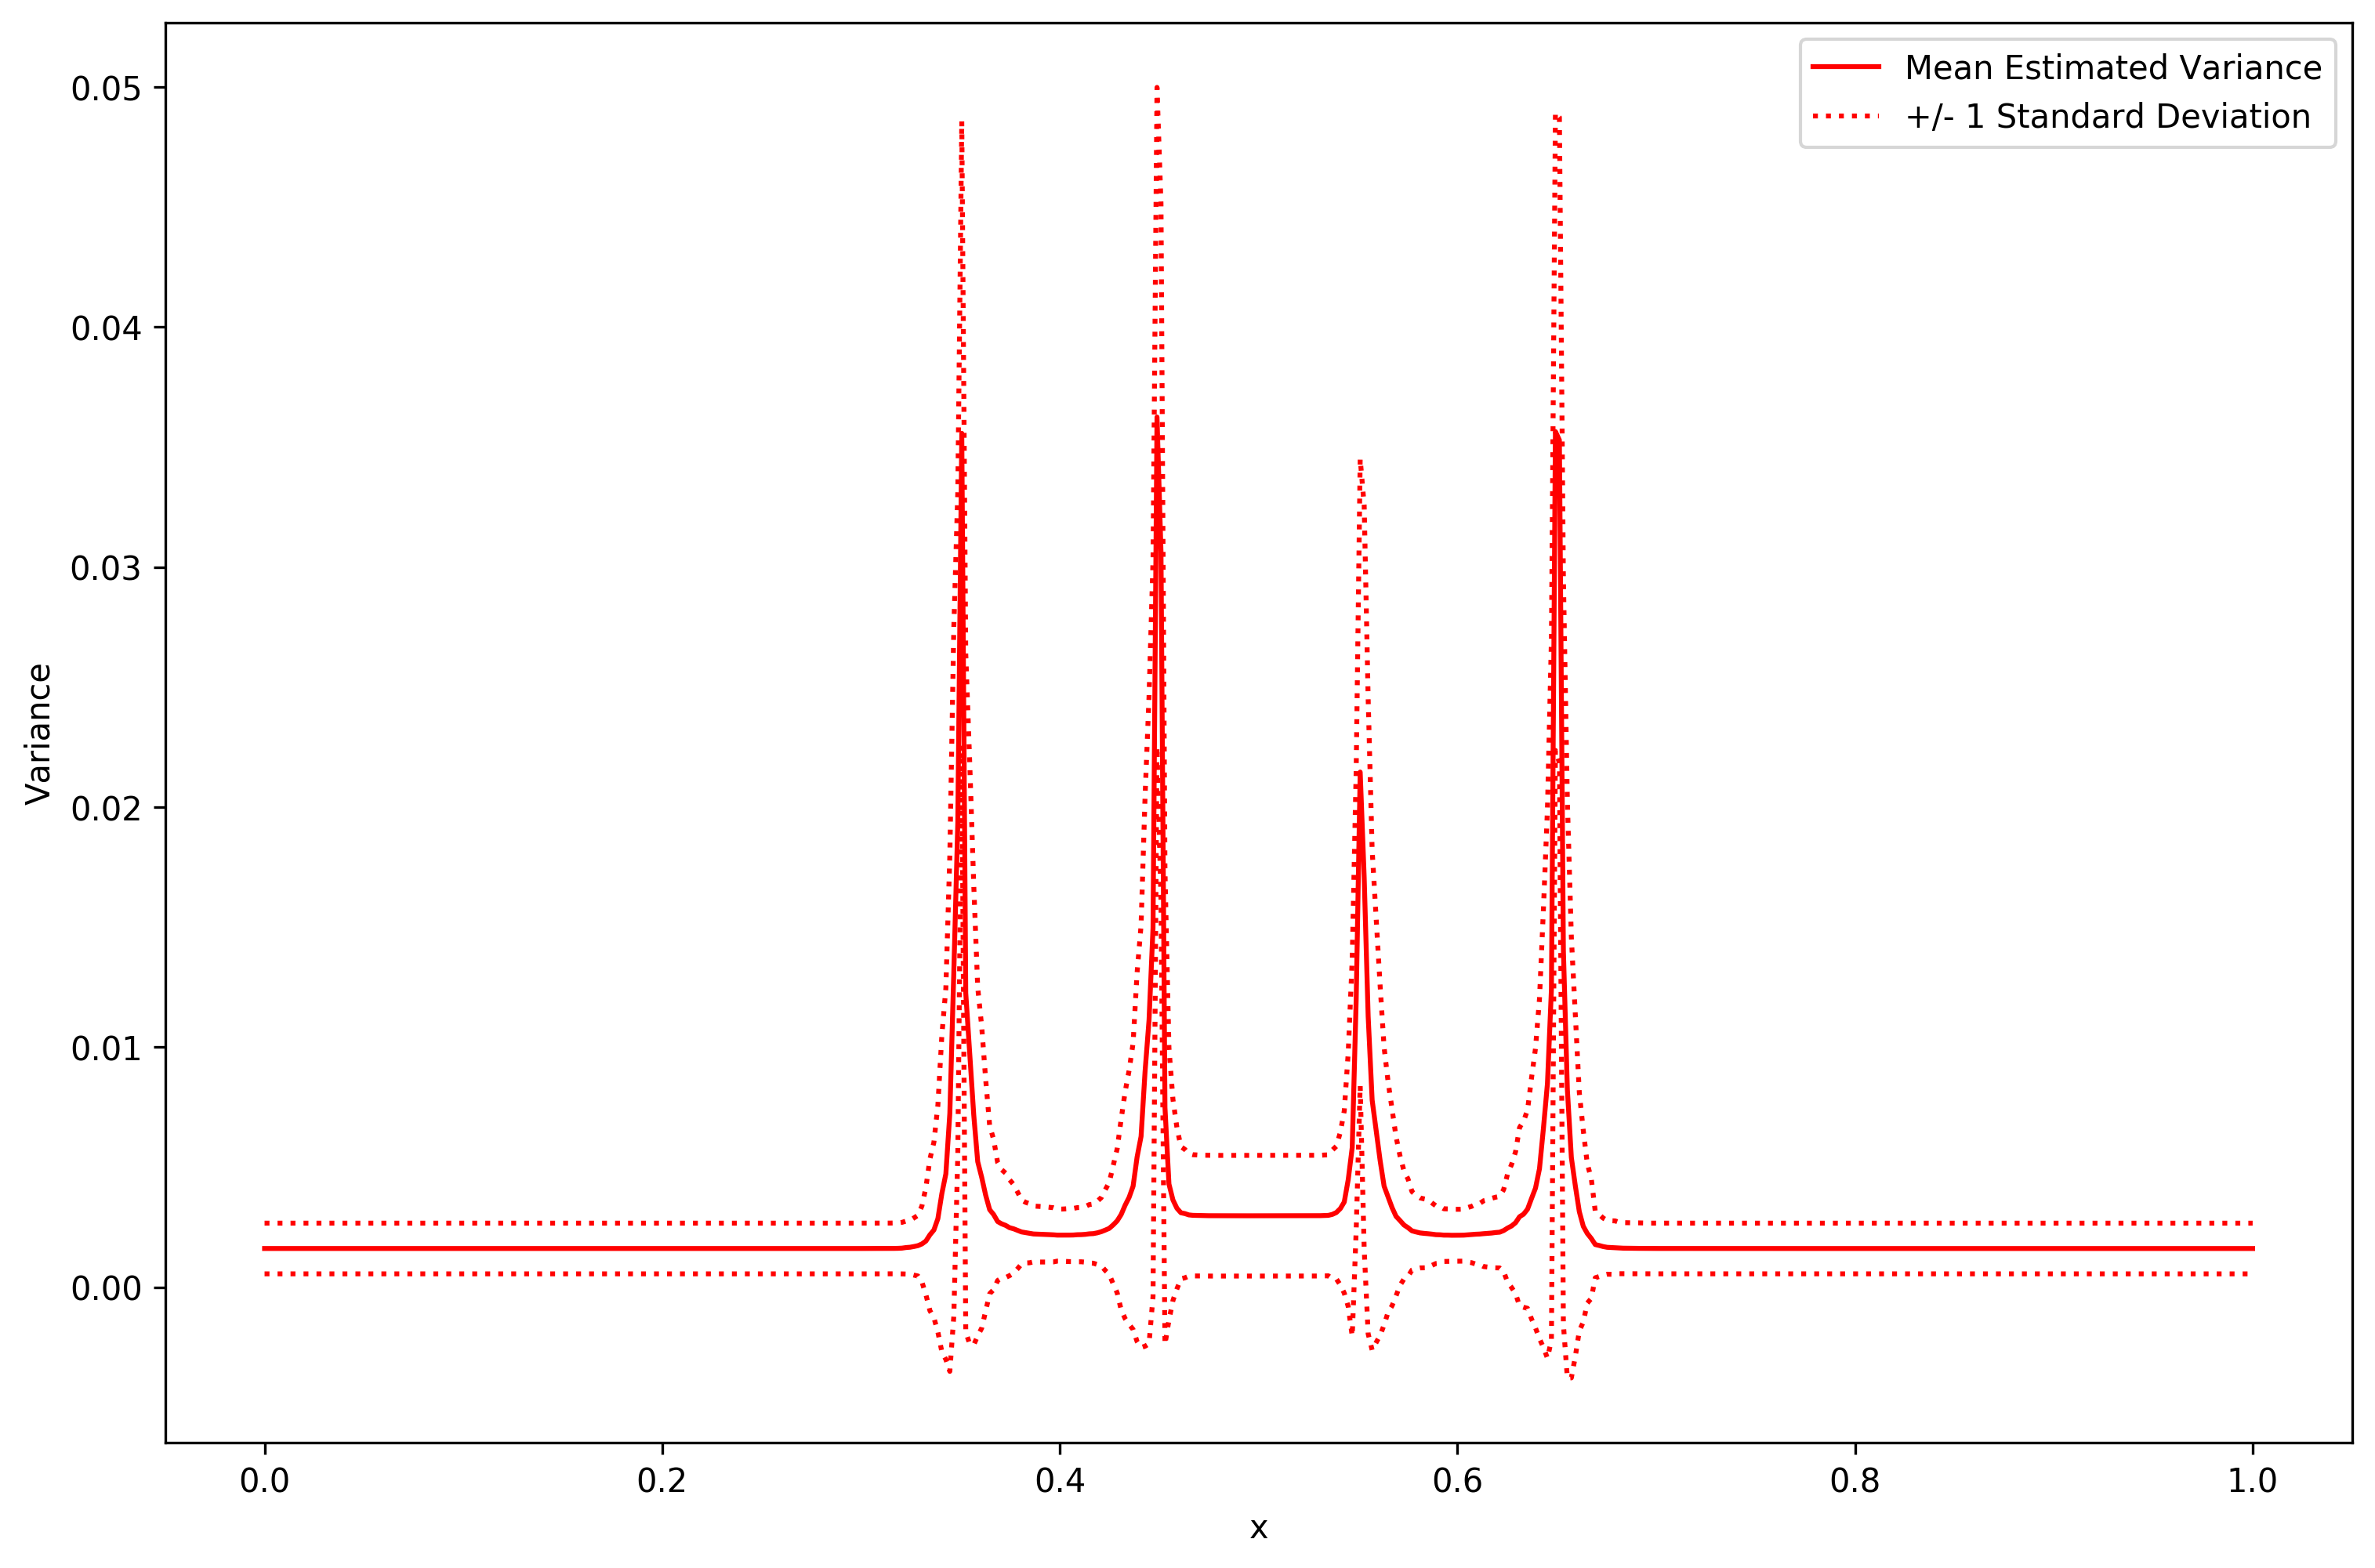

In [27]:
fig, ax = plt.subplots(figsize = (12, 8), dpi = 300)
X = np.linspace(0, 1, num=n, endpoint=True).reshape((-1, 1))
mean = collection_source.mean(axis = 0)
std = collection_source.std(axis = 0)
ax.plot(X.ravel(), mean.ravel(), 'r-', label = 'Mean Estimated Variance')
ax.plot(X.ravel(), mean.ravel() + std.ravel(), 'r:', label = '+/- 1 Standard Deviation')
ax.plot(X.ravel(), mean.ravel() - std.ravel(), 'r:')
plt.xlabel('x')
plt.ylabel('Variance') 
plt.legend()
plt.savefig('figure2.pdf', dpi = 300)
plt.show()

### Figure 3

In [13]:
df = pd.read_table('cholesterol.txt')